# Phase III: First ML Proof of Concept (5\%)

### Team Members:
- Deepanshu Bhagria 
- Ishaan Tayal
- Ignacio Torner Toledo
- Dev Patel

Due to the large amount of data in all our cleaned csv files, we had to randomly pick two csv files from two seasons this year, summer and winter, for two random months (January, July) to identify any patterns. This way, the graphing and analyzing will go more smoothly. Below you can see the new code for cleaning only required csv files:

In [115]:
# importing libraries 
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import probplot


In [116]:
def clean_stock_data(df):
    """
    Cleans stock data from yfinance:
    - Flattens MultiIndex columns
    - Resets index to make 'Date' a column
    - Drops missing values
    - Adds daily percent change and moving averages (5-day and 20-day)
    """
    # makes a copy of df
    df = df.copy()
    
    # Flatten MultiIndex columns
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [col[0] if col[1] else col[0] for col in df.columns]
    
    # Reset index so Date is a column
    df.reset_index(inplace=True)
    
    # Drop any rows with missing values
    df.dropna(subset=['Close', 'Volume'], inplace=True)
    
    # Convert Date to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Derived features
    df['Daily_Change'] = df['Close'].pct_change() * 100
    df['MA_5'] = df['Close'].rolling(5).mean()
    df['MA_20'] = df['Close'].rolling(20).mean()
    
    # Drop rows with NaN from rolling calculations
    df.dropna(inplace=True)
    
    return df

In [117]:
#Testing the pre-processes data
df = yf.download('AAPL', start='2015-01-01', end='2025-10-25')
df.head()

/var/folders/v4/rl51r6ks60z5gjpkw48kqr7h0000gn/T/ipykernel_36083/3804558087.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL', start='2015-01-01', end='2025-10-25')
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-01-02,24.237553,24.705322,23.798602,24.694237,212818400
2015-01-05,23.554741,24.086801,23.368521,24.006992,257142000
2015-01-06,23.556963,23.816342,23.195604,23.619036,263188400
2015-01-07,23.887270,23.987031,23.654493,23.765339,160423600
2015-01-08,24.805086,24.862726,24.097889,24.215387,237458000


In [118]:
print(df.columns)

MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])


In [119]:
# Test
# Printing first 5 rows of cleaned data
df_cleaned = clean_stock_data(df)
df_cleaned.head(1)

,Date,Close,High,Low,Open,Volume,Daily_Change,MA_5,MA_20
19,2015-01-30,25.973396,26.603,25.904671,26.248293,334982000,-1.463424,25.432912,24.5283


## Part 1
(3%) The implementation (using NumPy) of your first ML model as a function call to the cleaned data

## Attempt 1 - Linear Regression Model

adding bias column

In [120]:
#prof code
def add_bias_column(X):
    """
    Args:
        X (array): can be either 1-d or 2-d
    
    Returns:
        Xnew (array): the same array, but 2-d with a column of 1's in the first spot
    """
    # If the array is 1-d
    if len(X.shape) == 1:
        Xnew = np.column_stack([np.ones(X.shape[0]), X])
    
    # If the array is 2-d
    elif len(X.shape) == 2:
        bias_col = np.ones((X.shape[0], 1))
        Xnew = np.hstack([bias_col, X])
        
    else:
        raise ValueError("Input array must be either 1-d or 2-d")

    return Xnew

prepare_Xy

linear_reg_model

In [121]:
def line_of_best_fit(X, y):
    """
    Fits linear regression using the normal equation.
    Returns coefficient vector m.
    """
    X = add_bias_column(X)
    m = np.matmul(np.linalg.inv(np.matmul(X.T , X)), np.matmul(X.T, y))
    return m

 linear_regression_prediction

In [122]:
def linreg_predict(Xnew, ynew, m):
    """
    Computes predictions and evaluation metrics for a linear regression model.

    Args:
        Xnew (array): 1D or 2D array of predictor values (excluding bias column).
        ynew (array): 1D array of observed response values.
        m (array): 1D array of coefficients (including intercept) from line_of_best_fit.

    Returns:
        dict: Contains
            - 'ypreds': Predicted values
            - 'resids': Residuals (ynew - ypreds)
            - 'mse': Mean squared error
            - 'r2': Coefficient of determination (R²)
    """

    Xnew = add_bias_column(Xnew)
    ypreds = np.dot(Xnew, m)
    resids = np.round(ynew - ypreds, 10)
    mse = round((resids**2).mean(), 1)
    r2 = r2_score(ynew, ypreds)


    return {'ypreds': ypreds,
            'resids': resids,
            'mse': mse,
            'r2': r2}


eval-plots

In [123]:
def diagnostic_plots(y_pred, resids, title):
    """
    Generates standard diagnostic plots for regression analysis,
    including residual plots and normality checks.

    Args:
        y_pred (np.ndarray): Predicted response values
        resids (np.ndarray): Residuals (y_true - y_pred)
        title (str): Title for the plot figure
    """
    plt.figure(figsize=(14, 10))

    plt.subplot(2, 2, 1)
    plt.scatter(y_pred, resids, alpha=0.4)
    plt.axhline(0, color='red', linestyle='--')
    plt.title("Residuals vs Fitted")

    plt.subplot(2, 2, 2)
    plt.scatter(range(len(resids)), resids, alpha=0.4)
    plt.axhline(0, color='red', linestyle='--')
    plt.title("Residuals vs Order")

    plt.subplot(2, 2, 3)
    probplot(resids, dist="norm", plot=plt)
    plt.title("Normal Q-Q Plot")

    plt.subplot(2, 2, 4)
    plt.hist(resids, bins=30, edgecolor="black")
    plt.title("Histogram of Residuals")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


In [124]:
def evaluate_model(X, y, title):
    """
    Evaluates a regression model using a 70–30 time-ordered split.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, shuffle=False
    )

    m = line_of_best_fit(X_train, y_train)
    results = linreg_predict(X_test, y_test, m)

    print(title)
    print(f"MSE: {results['mse']:.3f}")
    print(f"R²: {results['r2']:.4f}\n")

    diagnostic_plots(results['ypreds'], results['resids'], title)
    return results

In [125]:
def prepare_linear_xy(df):
    """
    Feature matrix for linear regression.
    """
    X = df[['High', 'Low', 'Open', 'Volume',
            'Daily_Change', 'MA_5', 'MA_20']].values
    y = df['Close'].values
    return X, y

In [126]:
def prepare_daily_change_polynomial_xy(df, degree=4):
    """
    Polynomial regression using Daily Change only.
    """
    X = df['Daily_Change'].values.reshape(-1, 1)
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)[:, 1:]
    y = df['Close'].values
    return X_poly, y

In [127]:
def prepare_interaction_polynomial_xy(df, degree=4):
    """
    Polynomial regression with interaction terms.
    """
    X_open = df['Open'].values.reshape(-1, 1)
    X_high = df['High'].values.reshape(-1, 1)
    X_low = df['Low'].values.reshape(-1, 1)
    X_volume = df['Volume'].values.reshape(-1, 1)

    poly = PolynomialFeatures(degree=degree)
    X_open_poly = poly.fit_transform(X_open)[:, 1:]

    X_poly = np.concatenate([
        X_open_poly,
        X_open * X_high,
        X_open * X_low,
        X_open * X_volume,
        X_high * X_low,
        X_high * X_volume,
        X_low * X_volume
    ], axis=1)

    y = df['Close'].values
    return X_poly, y


In [128]:
def main_linear_regression():
    df_raw = yf.download('AAPL', start='2015-01-01', end='2025-10-25')
    df = clean_stock_data(df_raw)

    X, y = prepare_linear_xy(df)
    evaluate_model(X, y, "Linear Regression: AAPL Closing Price")

In [129]:
def main_polynomial_regression():
    df_raw = yf.download('AAPL', start='2015-01-01', end='2025-10-25')
    df = clean_stock_data(df_raw)

    X_poly, y = prepare_daily_change_polynomial_xy(df, degree=4)
    evaluate_model(X_poly, y, "Polynomial Regression (Daily Change, Degree 4)")

In [130]:

def main_polynomial_interaction_regression():
    df_raw = yf.download('AAPL', start='2015-01-01', end='2025-10-25')
    df = clean_stock_data(df_raw)

    X_poly, y = prepare_interaction_polynomial_xy(df, degree=4)
    evaluate_model(X_poly, y, "Polynomial Regression with Interaction Terms")

/var/folders/v4/rl51r6ks60z5gjpkw48kqr7h0000gn/T/ipykernel_36083/202089207.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_raw = yf.download('AAPL', start='2015-01-01', end='2025-10-25')
[*********************100%***********************]  1 of 1 completed
/var/folders/v4/rl51r6ks60z5gjpkw48kqr7h0000gn/T/ipykernel_36083/2477891498.py:7: RuntimeWarning: divide by zero encountered in matmul
  m = np.matmul(np.linalg.inv(np.matmul(X.T , X)), np.matmul(X.T, y))
/var/folders/v4/rl51r6ks60z5gjpkw48kqr7h0000gn/T/ipykernel_36083/2477891498.py:7: RuntimeWarning: overflow encountered in matmul
  m = np.matmul(np.linalg.inv(np.matmul(X.T , X)), np.matmul(X.T, y))
/var/folders/v4/rl51r6ks60z5gjpkw48kqr7h0000gn/T/ipykernel_36083/2477891498.py:7: RuntimeWarning: invalid value encountered in matmul
  m = np.matmul(np.linalg.inv(np.matmul(X.T , X)), np.matmul(X.T, y))


Linear Regression: AAPL Closing Price
MSE: 1.000
R²: 0.9991



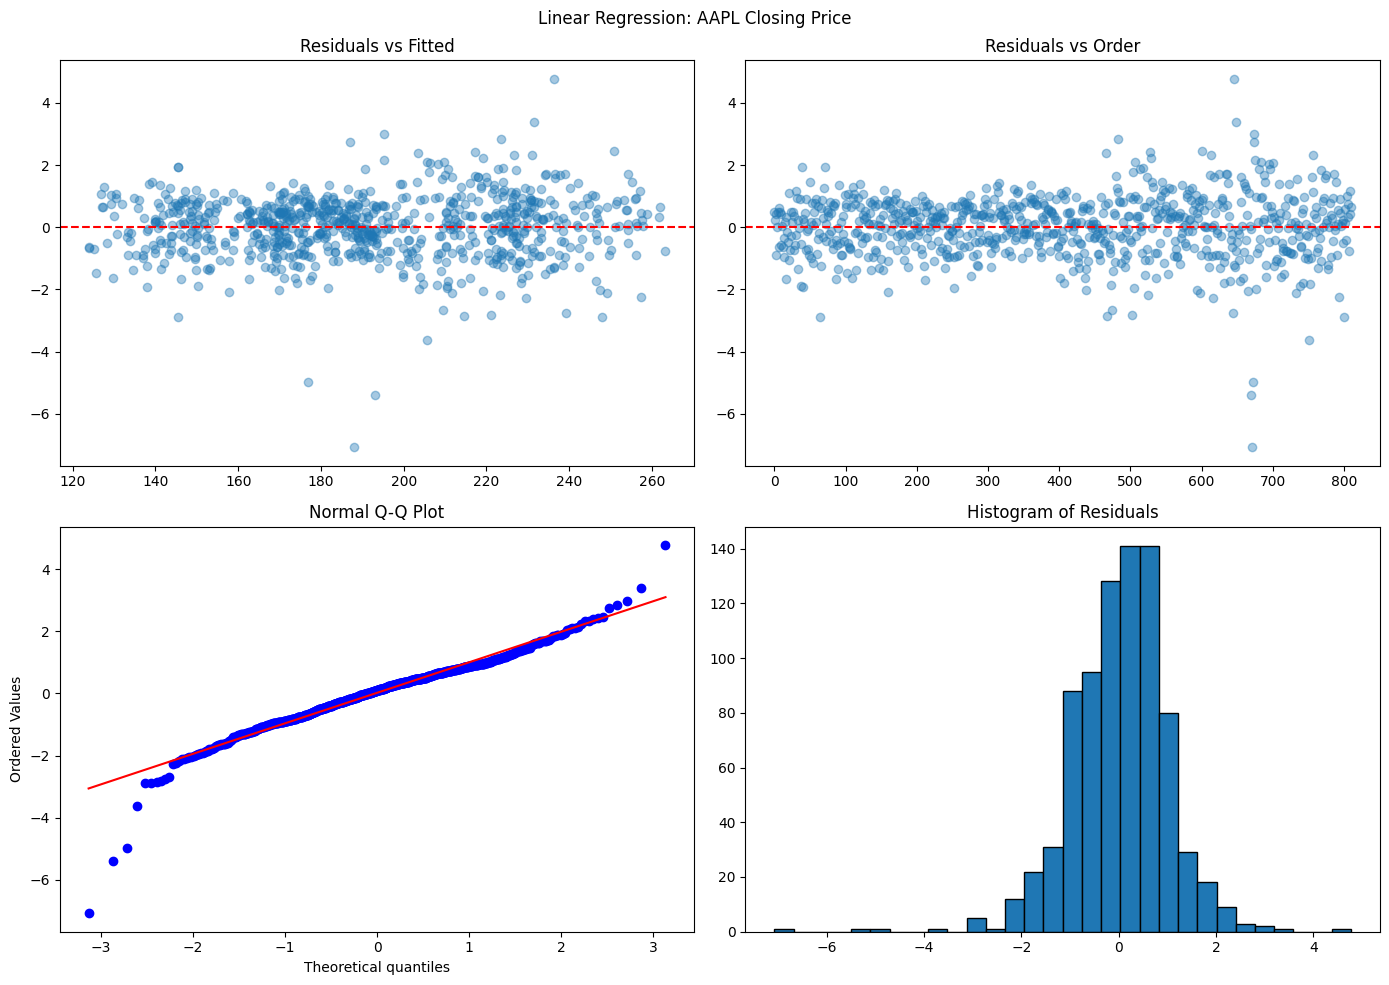

/var/folders/v4/rl51r6ks60z5gjpkw48kqr7h0000gn/T/ipykernel_36083/2015756613.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_raw = yf.download('AAPL', start='2015-01-01', end='2025-10-25')
[*********************100%***********************]  1 of 1 completed


Polynomial Regression (Daily Change, Degree 4)
MSE: 16982.400
R²: -14.4945



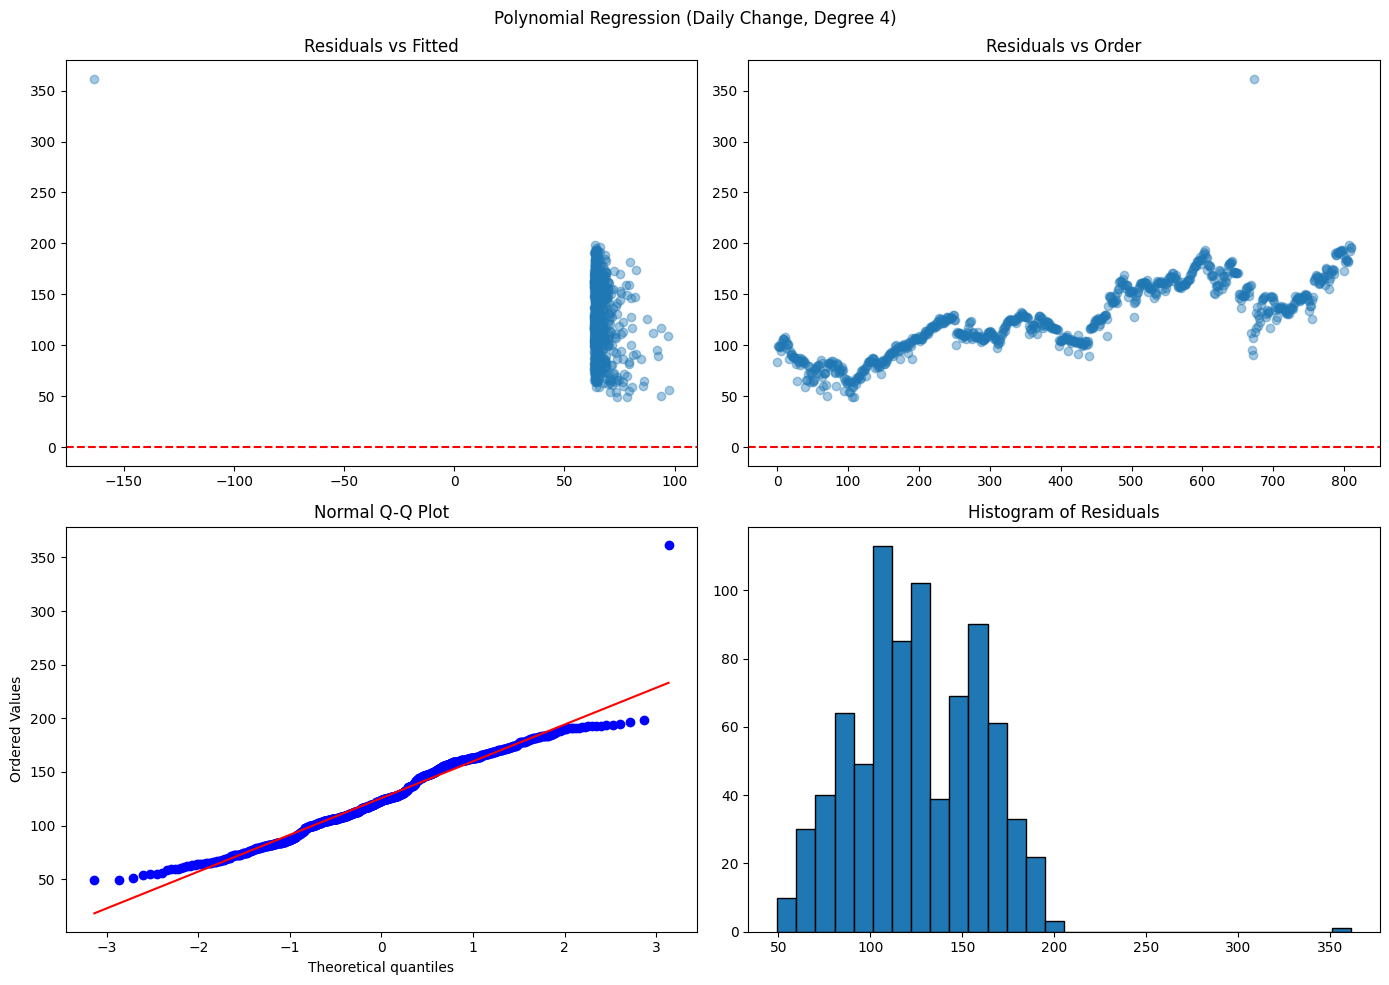

/var/folders/v4/rl51r6ks60z5gjpkw48kqr7h0000gn/T/ipykernel_36083/1995274272.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_raw = yf.download('AAPL', start='2015-01-01', end='2025-10-25')
[*********************100%***********************]  1 of 1 completed
/var/folders/v4/rl51r6ks60z5gjpkw48kqr7h0000gn/T/ipykernel_36083/2477891498.py:7: RuntimeWarning: divide by zero encountered in matmul
  m = np.matmul(np.linalg.inv(np.matmul(X.T , X)), np.matmul(X.T, y))
/var/folders/v4/rl51r6ks60z5gjpkw48kqr7h0000gn/T/ipykernel_36083/2477891498.py:7: RuntimeWarning: overflow encountered in matmul
  m = np.matmul(np.linalg.inv(np.matmul(X.T , X)), np.matmul(X.T, y))
/var/folders/v4/rl51r6ks60z5gjpkw48kqr7h0000gn/T/ipykernel_36083/2477891498.py:7: RuntimeWarning: invalid value encountered in matmul
  m = np.matmul(np.linalg.inv(np.matmul(X.T , X)), np.matmul(X.T, y))


Polynomial Regression with Interaction Terms
MSE: 2.600
R²: 0.9976



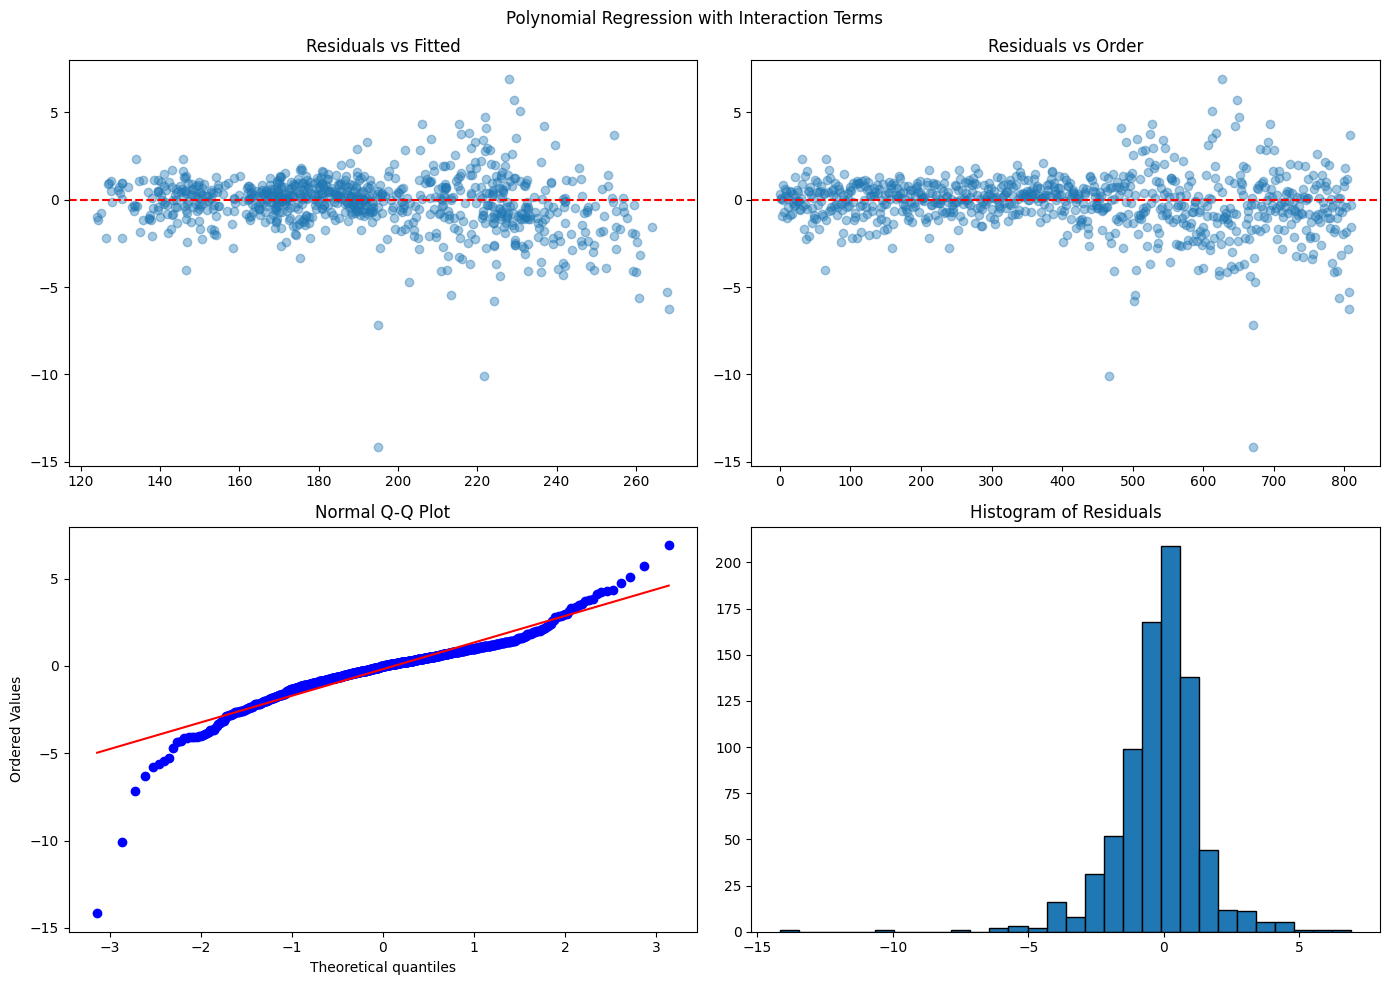

In [131]:
if __name__ == "__main__":
    main_linear_regression()
    main_polynomial_regression()
    main_polynomial_interaction_regression()

In [132]:
## Pyotorch model

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
# importing libraries 
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import probplot

In [133]:
# from your existing code
#Testing the pre-processes data
df_raw = yf.download('AAPL', start='2015-01-01', end='2025-10-25')
df_cleaned = clean_stock_data(df_raw)
X, y = prepare_linear_xy(df_cleaned)


/var/folders/v4/rl51r6ks60z5gjpkw48kqr7h0000gn/T/ipykernel_36083/2867462053.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_raw = yf.download('AAPL', start='2015-01-01', end='2025-10-25')
[*********************100%***********************]  1 of 1 completed


In [134]:
# Train-test split (time-ordered)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=False
)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1))
# y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1))


In [135]:
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)

y_train_t = torch.tensor(y_train_scaled, dtype=torch.float32).view(-1, 1)
y_test_t = torch.tensor(y_test_scaled, dtype=torch.float32).view(-1, 1)


In [136]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x)


In [137]:
input_dim = X_train.shape[1]
model = LinearRegressionModel(input_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [138]:
num_epochs = 1000
loss_history = []

for epoch in range(num_epochs):
    model.train()

    optimizer.zero_grad()

    predictions = model(X_train_t)
    loss = criterion(predictions, y_train_t)

    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [100/1000], Loss: 0.0601
Epoch [200/1000], Loss: 0.0209
Epoch [300/1000], Loss: 0.0069
Epoch [400/1000], Loss: 0.0025
Epoch [500/1000], Loss: 0.0013
Epoch [600/1000], Loss: 0.0009
Epoch [700/1000], Loss: 0.0009
Epoch [800/1000], Loss: 0.0008
Epoch [900/1000], Loss: 0.0008
Epoch [1000/1000], Loss: 0.0007


In [139]:
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_t)
    mse_test = criterion(y_pred_test, y_test_t)

# Convert to NumPy for R²
y_pred_np = y_pred_test.numpy().flatten()
y_test_np = y_test_t.numpy().flatten()

r2 = r2_score(y_test_np, y_pred_np)

print("\nPyTorch Model Evaluation")
print(f"Test MSE: {mse_test.item():.3f}")
print(f"Test R²: {r2:.4f}")



PyTorch Model Evaluation
Test MSE: 0.004
Test R²: 0.9929


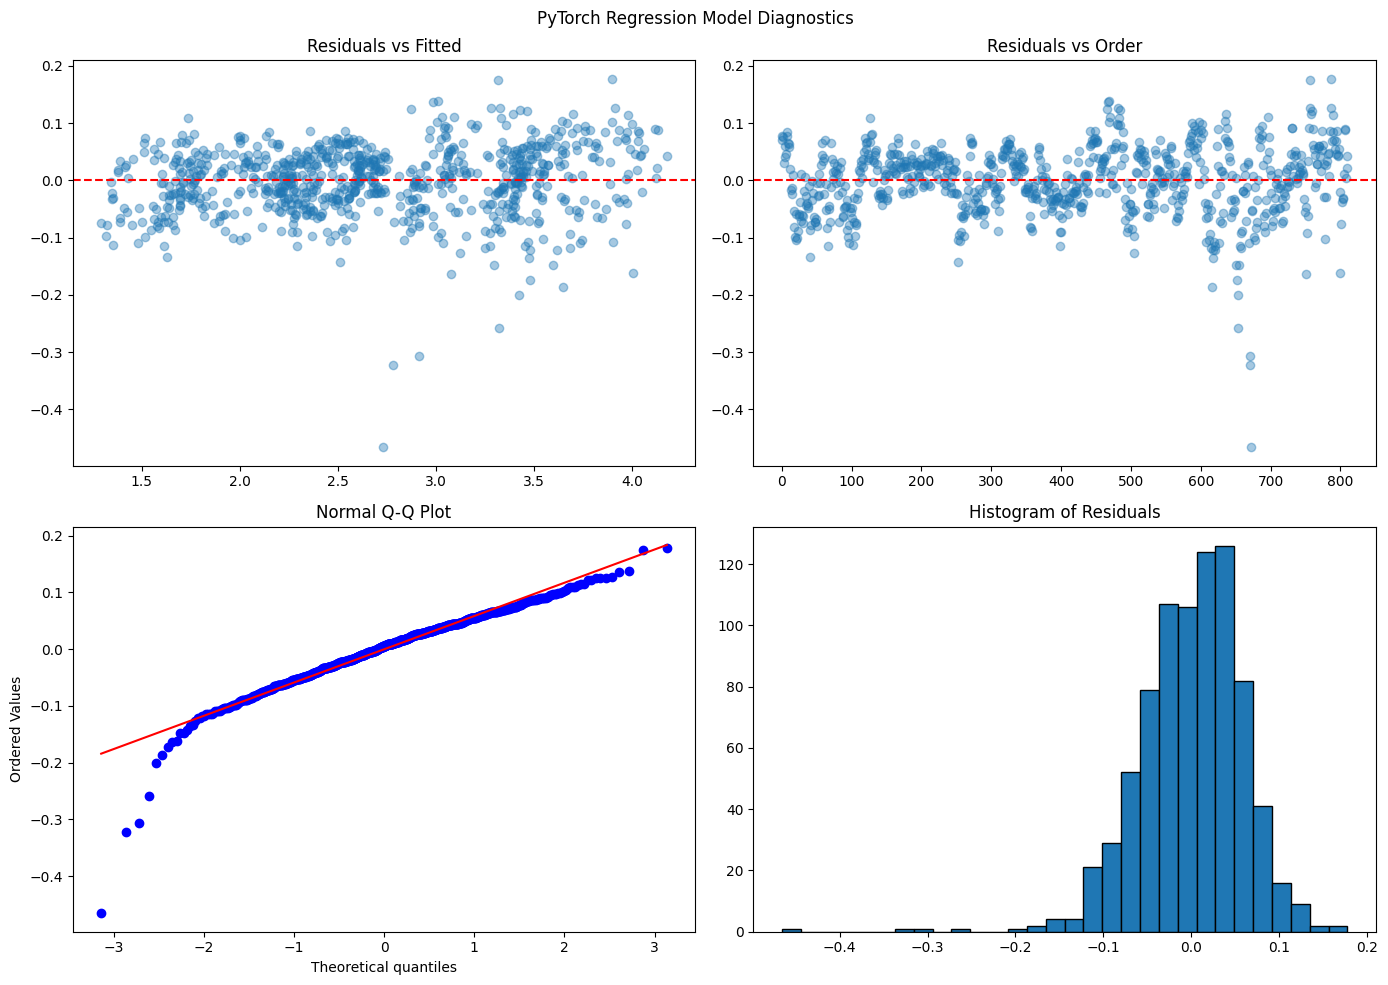

Test MSE: 0.004
Test R²: 0.9929


In [140]:
model.eval()

with torch.no_grad():
    y_pred_test = model(X_test_t)

y_pred_np = y_pred_test.cpu().numpy().flatten()
y_true_np = y_test_t.cpu().numpy().flatten()

resids = y_true_np - y_pred_np

diagnostic_plots(
    y_pred=y_pred_np,
    resids=resids,
    title="PyTorch Regression Model Diagnostics"
)
print(f"Test MSE: {mse_test.item():.3f}")
print(f"Test R²: {r2:.4f}")